In [14]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_masks_XZ import Scalar_mask_XZ
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.utils_math import get_k
from numpy.lib.scimath import sqrt as csqrt

from scipy.constants import c, epsilon_0, e, m_e, h
import numpy as np
import sympy as sp

from sympy.core.numbers import pi
from IPython.display import display
import numba
from numbalsoda import dop853, lsoda, lsoda_sig
from numba import njit, cfunc

%matplotlib widget


Here we ware going to use a light optics package to calculate the path of the electron. We can do this because in purely electrostatic systems, there is an electrostatic analogue of snells law. We can use this to test if the optical path length calculations of our ray tracing model actually work. We will test it again at a scale that for now is not physically accurate. If our ray tracing model recreates the fringe spacing, then we know that our optical path length calculations will work. 

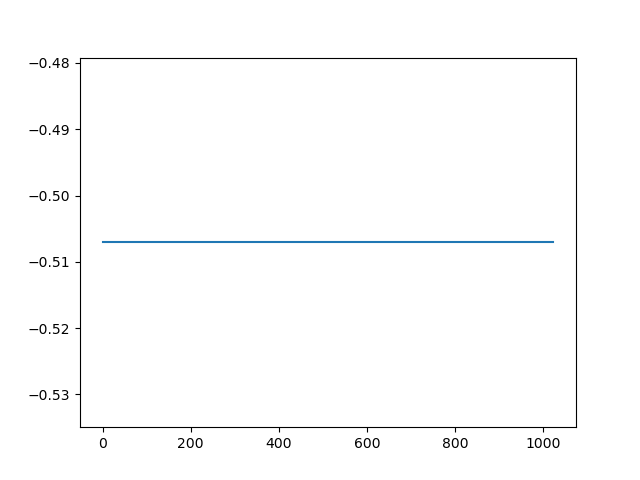

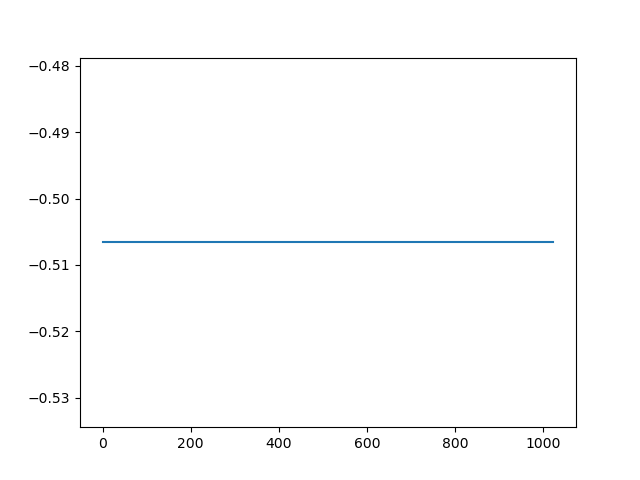

In [26]:
X, Y, Z = sp.symbols('X Y Z')

#Use scipy's constants
e = e #-1.60217662e-19 #unit C
m = m_e #9.10938356e-31 #unit kg
h_planck = h #6.62607015e-34 #unit J . s 
c_l = c #2.99792458e8 #unit m/s
eps_0_val = epsilon_0 #8.85418782e-12 #permittivity unit F/m
#eps = abs(e)/(2*m*c_l**2) #eps as defined in Hawkes, different from the permittivity of free space. 

#Set initial accelerating voltage. I know it's unrealistic but it gives an output that is easy to plot for now.
phi_0 = 0.5

#Calculate corresponding wavelength of the electron, and divide by 1e-6 so that everything is scaled around the micron unit (this is for the diffractio package)
wavelength = h/(2*abs(e)*m*phi_0)**(1/2)/1e-6

#Set voltage of biprism
V = 0.1

#Set radius of biprism wire
r = 0.125e-6/1e-6

#Set radius of the condenser surrounding the wire
R = 1e-5/1e-6

phi_biprism = V*(sp.log((X*X+(Z)**2)/(R**2)))/(2*sp.log(r/R))

#Here we write the "refractive index" that the electron would see, using the equation for the electrostatic potential. See Eq 5.17 in Hawkes Principles of Electron Optics
n_eq1 = (1+phi_biprism/phi_0)**(0.5)
n_eq1_lambda = sp.lambdify([Z, X], n_eq1)

n_eq2 = (2*m*abs(e)*(phi_0-phi_biprism))**(0.5)


#The equation needs to be written as a string for diffractio to be able to implement it, and we need to replace log with np.log in the expression.
#This is because diffractio uses the "eval" function which uses a string to form the function.
n = str(n_eq1).replace("log", "np.log")

#Set up the scale in x and z
x0 = np.linspace(-0.4 * um, 0.4 * um, 1024 * 1)
u0 = np.complex128(np.ones(x0.shape))

z0 = np.linspace(-2 * um, 0 * um, 2 * 1, endpoint = True)
zz0, xx0 = np.meshgrid(z0, x0)

n_eval = n_eq1_lambda(zz0, xx0)
n_eval = np.complex128(n_eval)
n_eval[np.where(np.sqrt(xx0**2 + zz0**2)<=r)] = 0.0 + 2.0j


#WPM Method
n0 = n_eval[:, 0]
n1 = n_eval[:, 1]

k0 = (2*np.pi)/wavelength
kx = get_k(x0, flavour = '+')
k_perp2 = kx**2


dz = 2 * um 

u_final = np.zeros_like(u0, dtype=complex)
Ek = np.fft.fftshift(np.fft.fft(u0))

refraction_indexes = np.unique(n1)
for m, n_m in enumerate(n1):
    H = np.exp(1j * dz * csqrt((n_m)**2 * k0**2 - k_perp2))
    u_temp = np.fft.ifft(np.fft.fftshift(H * Ek))
    u_final = u_final + u_temp

u1 = u0 + u_final

plt.figure()
plt.plot(np.angle(u_final))

plt.figure()
plt.plot(np.angle(u1))




In [16]:
print(np.min(abs(xx0)))

0.0003910068426197233


[-2.0, 0.0, -0.4, 0.4]
[0.03529473 0.03533477 0.0353749  ... 0.0353749  0.03533477 0.03529473]


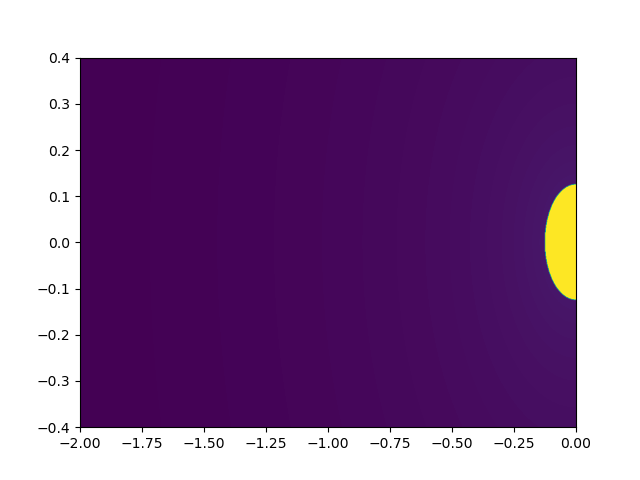

In [17]:



plt.figure()
extension = [z0[0], z0[-1], x0[0], x0[-1]]
print(extension)
h1 = plt.imshow(np.abs(n_eval),
                interpolation='bilinear',
                aspect='auto',
                origin='lower',
                extent=extension)


print(delta_n)



In [18]:
#Create a source plane wave
u0 = np.ones((x0.shape), dtype = np.complex128)
Ek = np.fft.fftshift(np.fft.fft(u))
H = np.exp(1j * 1 * mm * csqrt())


NameError: name 'u' is not defined

Plot the results

In [ ]:
#Perform the calculation with the wave propagation method
t0.WPM(verbose=True, has_edges=False)

In [ ]:
t0.draw(kind='intensity', draw_borders=True)

In [ ]:
t0.draw(kind='phase', draw_borders=True)

In [ ]:
u_field_last_plane = t0.profile_transversal(z0= 3 * um, normalize = 'maximum')
wave_ax = plt.gca()
wave_fig = plt.gcf()
plt.xlim([-0.08, 0.08])

I might also be good to get an interference pattern with RayLeigh Sommerfeld method (this does not work for now)

In [ ]:
u1 = t0.n[:, np.argmin(abs(z0)-z0)]
t1 = Scalar_mask_X(x0, wavelength)
t1.u = u1
u1 = t1 * u0

u2 = u1.RS(z=3 * um, new_field = True)

#plt.figure()
#plt.plot(x0, np.abs(u2.u))